# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from glob import glob

from random import seed
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(0)
rng = np.random.default_rng()

## Mount drive

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## Part 1: Basic Filters

In [3]:
filepath_acclerometer = "/content/drive/MyDrive/Notebook/Data/accelerometer.csv"
filepath_gyroscope = "/content/drive/MyDrive/Notebook/Data/gyroscope.csv"

### Read Data with `pd.read_csv`
`df.head()` will return top 5 rows.

In [4]:
df = pd.read_csv(filepath_acclerometer)
df.head()

,time,gFx,gFy,gFz,TgF
0,5.014,-0.6415,-0.6753,0.1064,0.938
1,5.014,-0.7915,-0.5771,0.1176,0.987
2,5.014,-0.7755,-0.5597,0.0701,0.959
3,5.015,-0.6608,-0.6224,0.0154,0.908
4,5.015,-0.6199,-0.6842,-0.0007,0.923


### Plot data

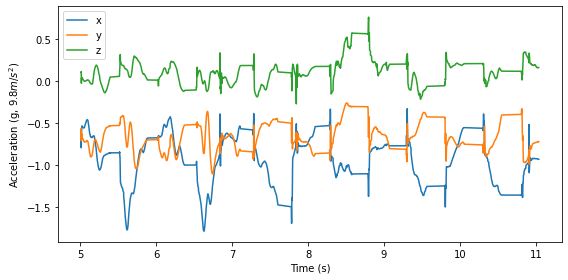

In [5]:
# Prepare X, Y data
X = df['time']
Y = df[['gFx', 'gFy', 'gFz']]

# Plot data
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(X, Y)
ax.legend('xyz')       # 범례
ax.set_xlabel('Time (s)') # x축 라벨
ax.set_ylabel('Acceleration (g, $9.8m/s^2$)') # y축 라벨
fig.tight_layout() # 정렬
fig.show()

### Plot Size of Acceleration

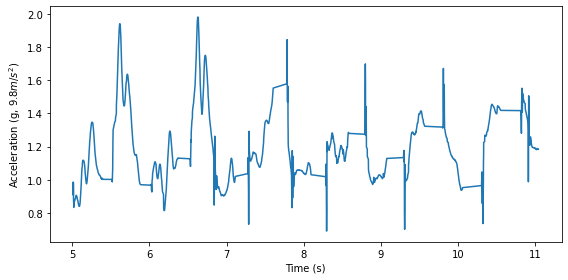

In [6]:
# Multiple graphs
fig, ax = plt.subplots(figsize=(8,4))

X = df['time']
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Plot data
ax.plot(X, Y)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.tight_layout()
fig.show()

### Moving average filter

In [7]:
def moving_average_filter(Y, window_size):
    # Original length
    length = Y.shape[0]
    
    # Filtered length
    filtered_length = length - (window_size - 1)
    
    # Get moving average
    Y_filtered = []
    for i in range(filtered_length):
        s = np.mean(Y[i:i+window_size])
        Y_filtered.append(s)
        
    return np.array(Y_filtered)

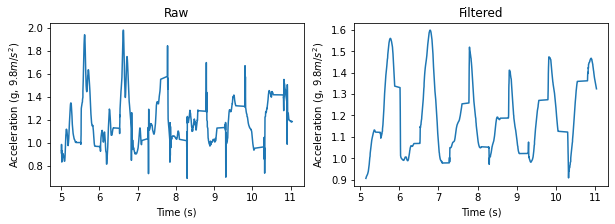

In [8]:
window_size = 100

# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
Y_filtered = moving_average_filter(Y, window_size)

# Plot data
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].plot(X, Y)
axes[1].plot(X[window_size - 1:], Y_filtered)

axes[0].set_title('Raw')
axes[1].set_title('Filtered')
for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.show()

### Median filter

In [9]:
def median_filter(Y, window_size):
    # Original length
    length = Y.shape[0]
    
    # Filtered length
    filtered_length = length - (window_size - 1)
    
    # Get median
    Y_filtered = []
    for i in range(filtered_length):
        s = np.median(Y[i:i+window_size])
        Y_filtered.append(s)
        
    return np.array(Y_filtered)

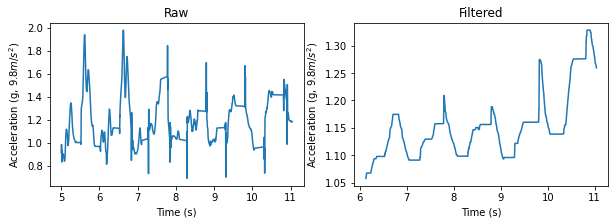

In [10]:
window_size = 500

# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
Y_filtered = median_filter(Y, window_size)

# Plot data
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
axes[0].plot(X, Y)
axes[1].plot(X[window_size - 1:], Y_filtered)
axes[0].set_title('Raw')
axes[1].set_title('Filtered')
for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.show()

### Low-pass filter

Exponentially weighted moving average filter

In [11]:
def ewma_filter(Y, alpha = 0.5):
    Y_filtered = []
    
    for i in range(Y.shape[0]):
        filtered = 0
        if i == 0:
            filtered  = Y[i]
        else:
            filtered = alpha*Y[i] + (1-alpha)*Y_filtered[-1]
        Y_filtered.append(filtered)

    return np.array(Y_filtered)

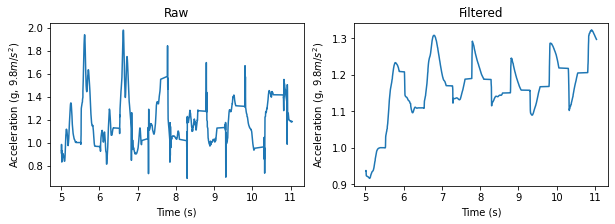

In [12]:
# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
fs = X.shape[0] / (X.iloc[-1] - X.iloc[0])
Y_filtered = ewma_filter(Y, 2/fs)

# Plot data
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
axes[0].plot(X, Y)
axes[1].plot(X, Y_filtered)
axes[0].set_title('Raw')
axes[1].set_title('Filtered')
for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.show()

low-pass filtering using scipy.signal.butter

In [13]:
from scipy.signal import butter, lfilter

def low_pass_filter(data, threshold, order=5):
    b, a = butter(order, threshold, btype='low')
    return lfilter(b, a, data)

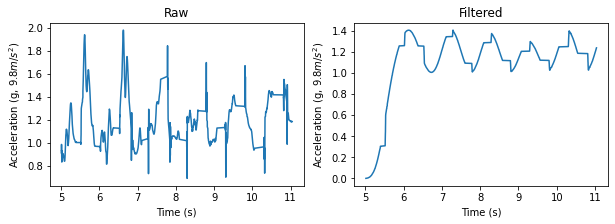

In [14]:
# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
fs = X.shape[0] / (X.iloc[-1] - X.iloc[0])
Y_filtered = low_pass_filter(Y, 2/fs)

# Plot data
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
axes[0].plot(X, Y)
axes[1].plot(X, Y_filtered)
axes[0].set_title('Raw')
axes[1].set_title('Filtered')
for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.show()

### Exercise: repeat the same process with gyroscope data

### Gyroscope data can be read by following

In [15]:
# Load data
df = pd.read_csv(filepath_gyroscope)

X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']], axis=1)

## Part 2: Frequency Domain Analysis

### Visualize frequency components using FFT

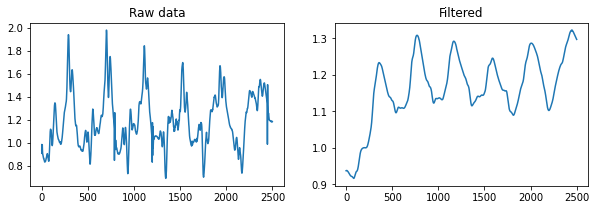

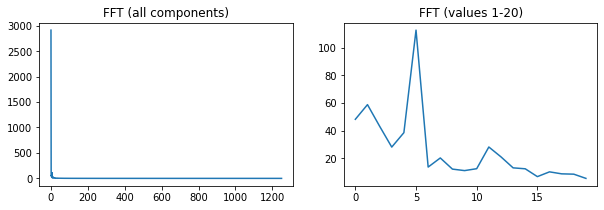

In [16]:
# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
fs = X.shape[0] / (X.iloc[-1] - X.iloc[0])
Y_filtered = ewma_filter(Y, 2/fs)

fig, ax = plt.subplots(ncols=2, figsize=(10,3))
ax[0].plot(Y)       # Plot all values after FFT
ax[0].set_title("Raw data")
ax[1].plot(Y_filtered)       # Plot all values after FFT
ax[1].set_title("Filtered")
fig.show()

fig, ax = plt.subplots(ncols=2, figsize=(10,3))
ax[0].plot(np.abs(np.fft.rfft(Y_filtered)))       # Plot all values after FFT
ax[0].set_title("FFT (all components)")
ax[1].plot(np.abs(np.fft.rfft(Y_filtered))[1:21]) # Plot 1~20 values after FFT
ax[1].set_title("FFT (values 1-20)")
fig.show()

### Exercise: see the FFT results of different filters

### Peak detection on frequency spectrum

In [17]:
def count_peaks_with_fft(Y):
    Y_fft = np.abs(np.fft.rfft(Y))[1:]
    count = np.argmax(Y_fft, axis=0) + 1
    return count

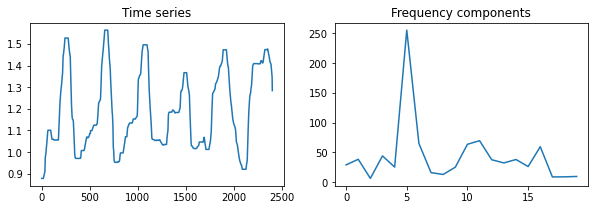

Detected peaks: 6


In [18]:
window_size = 100

# Load data
df = pd.read_csv(filepath_acclerometer)

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
Y = median_filter(Y, window_size)

# Count peaks
count = count_peaks_with_fft(Y)

# Plot data
fig, ax = plt.subplots(ncols=2, figsize=(10,3))
ax[0].plot(Y)
ax[0].set_title("Time series")

ax[1].plot(np.abs(np.fft.rfft(Y))[1:21]) # Plot 1~20 values after FFT
ax[1].set_title("Frequency components")
plt.show()

print(f'Detected peaks: {count}')

### Exercise: repeat the same process with gyroscope data

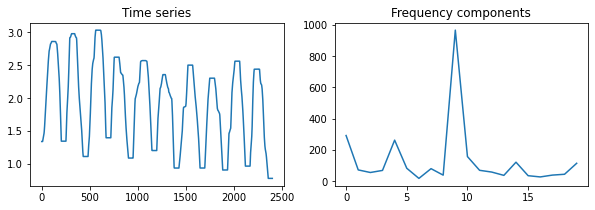

Detected peaks: 10


In [19]:
window_size = 100

# Load data
df = pd.read_csv(filepath_gyroscope)

# Get size of acceleration
Y = np.linalg.norm(df[['wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']], axis=1)

# Filter data
Y = median_filter(Y, window_size)

# Count peaks
count = count_peaks_with_fft(Y)

# Plot data
fig, ax = plt.subplots(ncols=2, figsize=(10,3))
ax[0].plot(Y)
ax[0].set_title("Time series")

ax[1].plot(np.abs(np.fft.rfft(Y))[1:21]) # Plot 1~20 values after FFT
ax[1].set_title("Frequency components")
plt.show()

print(f'Detected peaks: {count}')